## Predicting Heart Disease

According to the British Heart Foundation, 27% of all deaths can be attributed to heart disease, Roughly 175,000 deaths per year.

Many factors contribute to heart disease. Some common ones are: poor sleep, poor diet, lack of exercise and obesity. Being able to risk factors in heart disease would be useful in helping to prevent patients prematurely dying. 

In this project, I used a dataset from Kaggle and made a K Nearest Neighbors algorithm to predict heart disease in patients

### Part 1: Exploratory data analysis

We will start with exploring our dataset. As per the source, each patient has the following information collected about them:

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

#reading in data
hdp = pd.read_csv("heart_disease_prediction.csv")

#Snapshot of data and shape
print("Data shape:", hdp.shape)
hdp.head()

Data shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
print(hdp.dtypes)
hdp.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

There are 6 numerical columns, and 5 categorical columns. However, on inspecting the dataset the columns HeartDisease and FastingBS are also categorical. 

In [3]:
hdp.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Now that we have seen that there are no obvious null values, let's have a deeper look.

In [4]:
hdp.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In terms of what stands out to me, I think that rest  BP and cholesterol have some null values as it's impossible to be 0. The dataset is always weighted for older people.

Looking at the descriptive statistics, we can see that the min value for FastingBP and Cholesterol are both 0. Using my background knowledge, I know that these values are errors. Let's fix that.

In [5]:
num_nulls = hdp[hdp["RestingBP"] == 0]
print(len(num_nulls))

num_nulls_cho = hdp[hdp["Cholesterol"] == 0]
print(len(num_nulls_cho))

1
172


For the RestingBP column, there's only 1 error. Therefore, we won't lose too much data by removing the row. However, with the Cholesterol column, there's 172 errors. Deleting that many rows would mean losing a lot of data. Therefore I'll replace the error value with the medians for people with heart disease and people without heart disease.

In [6]:
hdp_clean = hdp[hdp["RestingBP"] != 0]


In [7]:
heartdisease_mask = hdp_clean["HeartDisease"]==0

cholesterol_without_heartdisease = hdp_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = hdp_clean.loc[~heartdisease_mask, "Cholesterol"]

hdp_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
hdp_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

Now that has been sorted, let's investigate the categorical data.

In [8]:
print(hdp_clean["FastingBS"].unique(), hdp["HeartDisease"].unique())
hdp.describe(include=['object'])

[0 1] [0 1]


,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


This confirms that the categorical data is indeed categorical, aswell as BastingBS and HeartDisease. Let's begin to compare the categorical data.

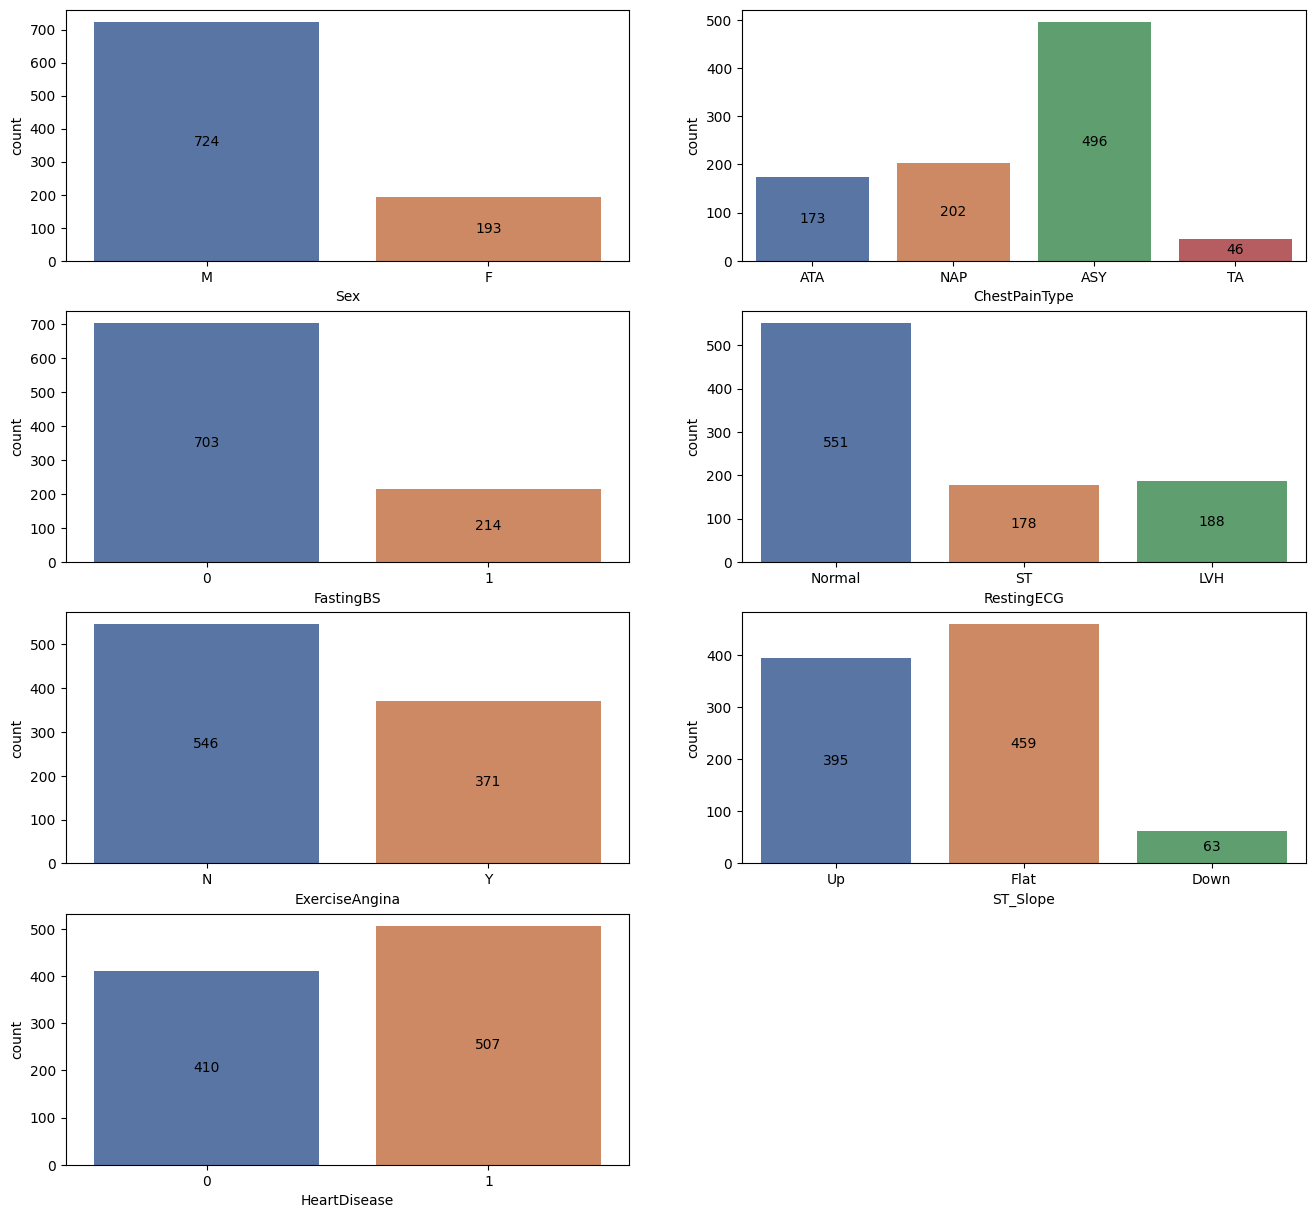

In [9]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for indx,col in enumerate (categorical_cols):
    ax = plt.subplot(4,2, indx + 1)
    sns.countplot(x = hdp_clean[col], ax=ax, hue = hdp_clean[col], legend = False, palette = "deep")
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Having a look at the graphs, we can see a potential problem with the date. The majority of patients are male, which calls into question the accuracy of the results for female patients. We will bear this in mind for now.

Patients with and without heart disease are roughly similar.

In terms of chest pain, we can see that the highest is asymptomatic. Grouping the data by the HeartDisease column may help give us a clearer insight.

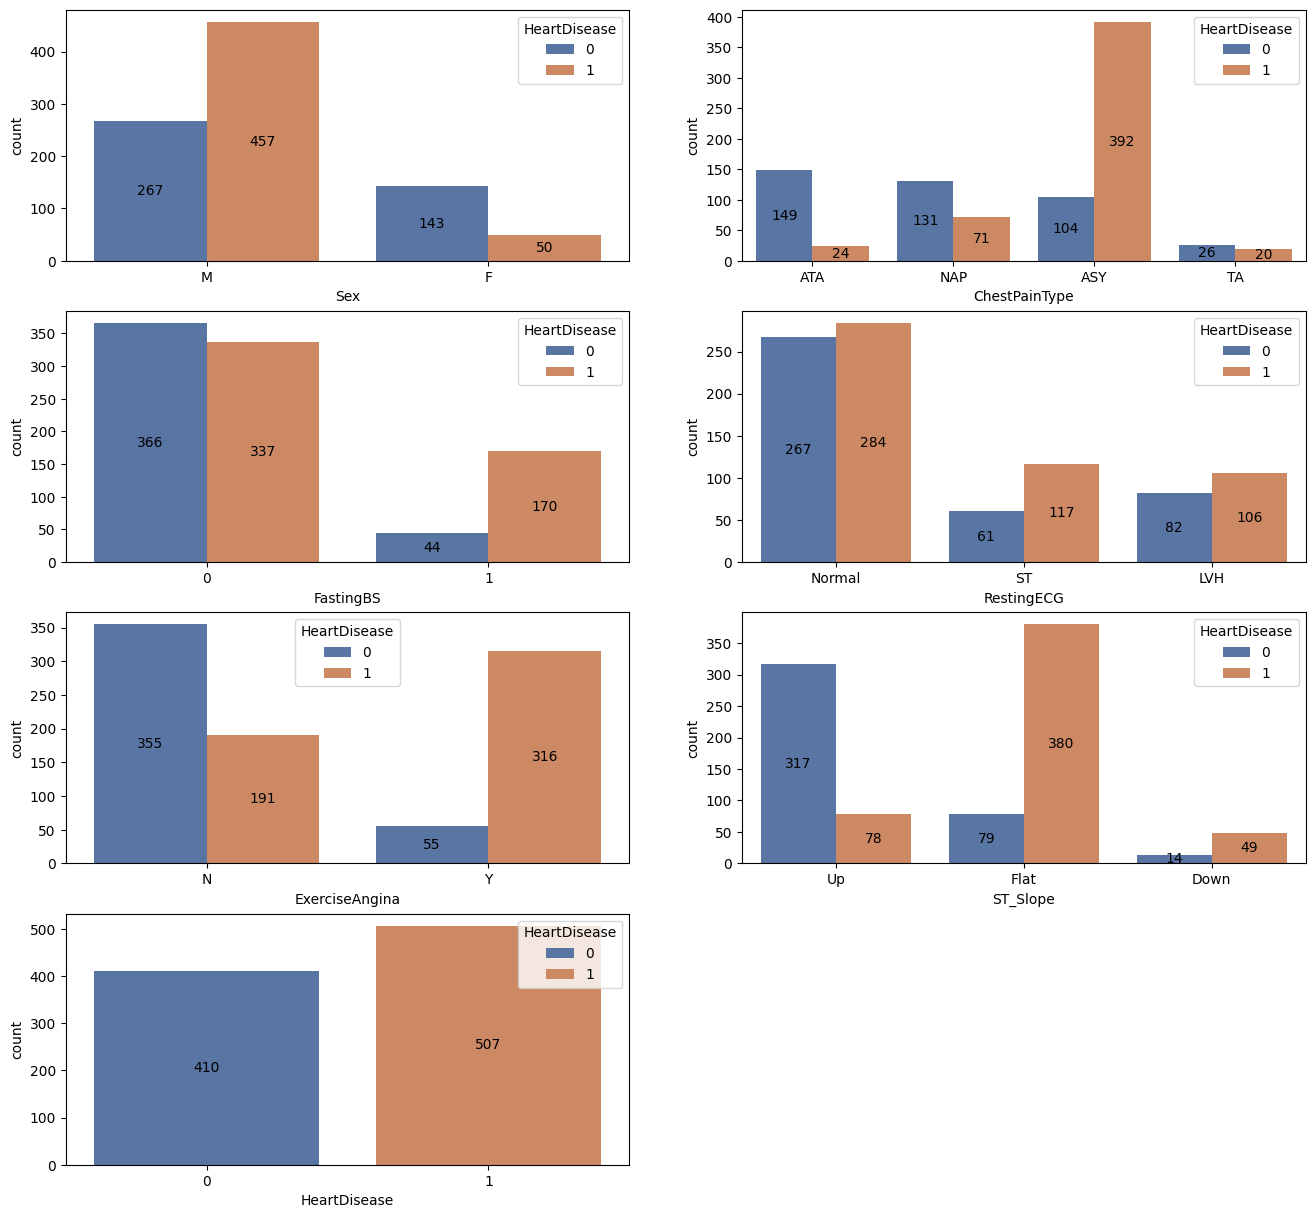

In [10]:
categorical_cols_grouped = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

fig = plt.figure(figsize=(16,15))

for indx,col in enumerate (categorical_cols):
    ax = plt.subplot(4,2, indx + 1)
    sns.countplot(x = hdp_clean[col], ax=ax, hue = hdp_clean["HeartDisease"], palette = "deep")
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Looking at the grouped data, we can see that in terms of ChestPainType asymptomatic is primarily people with heart disease. Another clear predictor is whether the patient suffers from angina whilst exercising. Finally, the type of ST slope is also key. If the patient has an up slope, they are much more likely to not have heart diease. On the other hand, if the have a flat slope they are much more likely to suffer from heart disease. Let's have a deeper look into some more common indicaters of heart diease.

<Axes: ylabel='Frequency'>

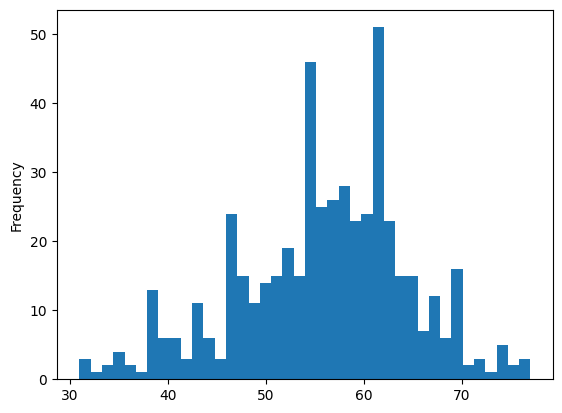

In [11]:
heart_disease = hdp_clean[hdp_clean["HeartDisease"] == 1]

heart_disease["Age"].plot.hist(bins = 40)

In [12]:
heart_disease["Age"].median()

np.float64(57.0)

Looking at the histogram plot, we can see that heart disease tends to occur between the ages of 50 to 65, with a median age of 57 years. This will be very useful in knowing when a prediction of heart disease may become true.

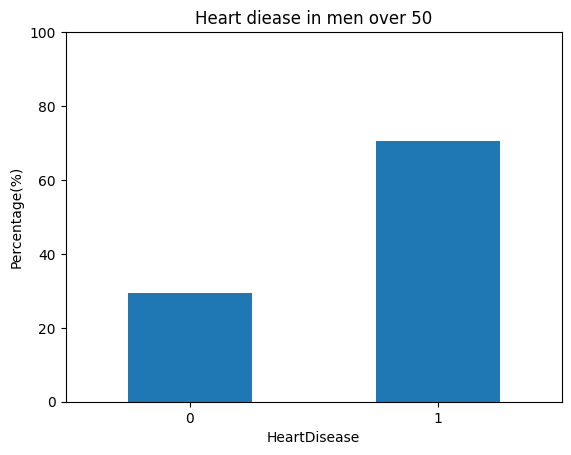

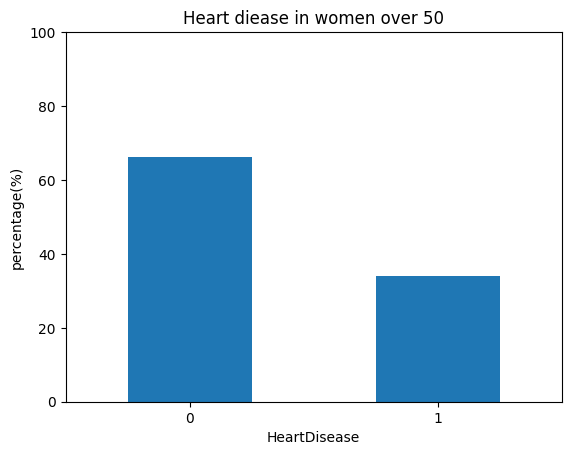

In [13]:
over_50_men = hdp_clean[(hdp_clean["Age"] > 50) & (hdp_clean["Sex"] == "M")]
over_50_women = hdp_clean[(hdp_clean["Age"] > 50) & (hdp_clean["Sex"] == "F")]

men_barplot_data = over_50_men["HeartDisease"].value_counts(sort = False, normalize = True) * 100
men_barplot_data.plot.bar()
plt.xticks(rotation = 360)
plt.title("Heart diease in men over 50")
plt.ylabel("Percentage(%)")
plt.ylim(0,100)
plt.show()

women_barplot_data = over_50_women["HeartDisease"].value_counts(sort = False, normalize = True) * 100
women_barplot_data.plot.bar()
plt.xticks(rotation = 360)
plt.title("Heart diease in women over 50")
plt.ylabel("percentage(%)")
plt.ylim(0,100)
plt.show()

From the above barplots, we can see that the majority of men over 50 (70%) have heart diease, whilst only minority of women over 50 (35%) have heart disease. This further supports the idea that the dataset is weighted towards men, and therefore should be used with caution when discussing predictions of heart disease in women.

## Part 2: Using a K nearest Neighbors algorithm to predict heart disease

Now that the data has been cleaned and we understand the context of the dataset better, let's try to predict heart disease using the dataset.

In [14]:
#This allow us to use nominal in our prediction
hdp_clean = pd.get_dummies(data=hdp, columns=["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"], drop_first= True)



In [15]:
hdp_corr = hdp_clean.corr().abs()

hdp_corr

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
Age,1.000000,0.254399,0.095282,0.382045,0.258612,0.282039,0.055750,0.218165,0.011335,0.032042,0.198039,0.230566,0.136798,0.215793,0.185568,0.258067
RestingBP,0.254399,1.000000,0.100893,0.112135,0.164803,0.107589,0.005133,0.046153,0.041348,0.049855,0.070193,0.116851,0.090447,0.155101,0.099207,0.096146
Cholesterol,0.095282,0.100893,1.000000,0.235792,0.050148,0.232741,0.200092,0.150954,0.006634,0.017365,0.260974,0.038470,0.133106,0.034166,0.050953,0.094027
MaxHR,0.382045,0.112135,0.235792,1.000000,0.160691,0.400421,0.189186,0.253735,0.134580,0.100025,0.131438,0.023801,0.157879,0.370425,0.342581,0.383397
Oldpeak,0.258612,0.164803,0.050148,0.160691,1.000000,0.403951,0.105734,0.262124,0.106212,0.032231,0.052698,0.116719,0.055958,0.408752,0.283295,0.450577
HeartDisease,0.282039,0.107589,0.232741,0.400421,0.403951,1.000000,0.305445,0.401924,0.212964,0.054790,0.267291,0.091580,0.102527,0.494282,0.554134,0.622164
Sex_M,0.055750,0.005133,0.200092,0.189186,0.105734,0.305445,1.000000,0.161522,0.066486,0.004031,0.120076,0.010634,0.063715,0.190664,0.116077,0.150942
ChestPainType_ATA,0.218165,0.046153,0.150954,0.253735,0.262124,0.401924,0.161522,1.000000,0.256767,0.110679,0.140514,0.107941,0.046111,0.300365,0.304667,0.357588
ChestPainType_NAP,0.011335,0.041348,0.006634,0.134580,0.106212,0.212964,0.066486,0.256767,1.000000,0.122381,0.039249,0.005010,0.042236,0.166030,0.072031,0.093583
ChestPainType_TA,0.032042,0.049855,0.017365,0.100025,0.032231,0.054790,0.004031,0.110679,0.122381,1.000000,0.026885,0.057719,0.011611,0.128105,0.010486,0.002087


<Axes: >

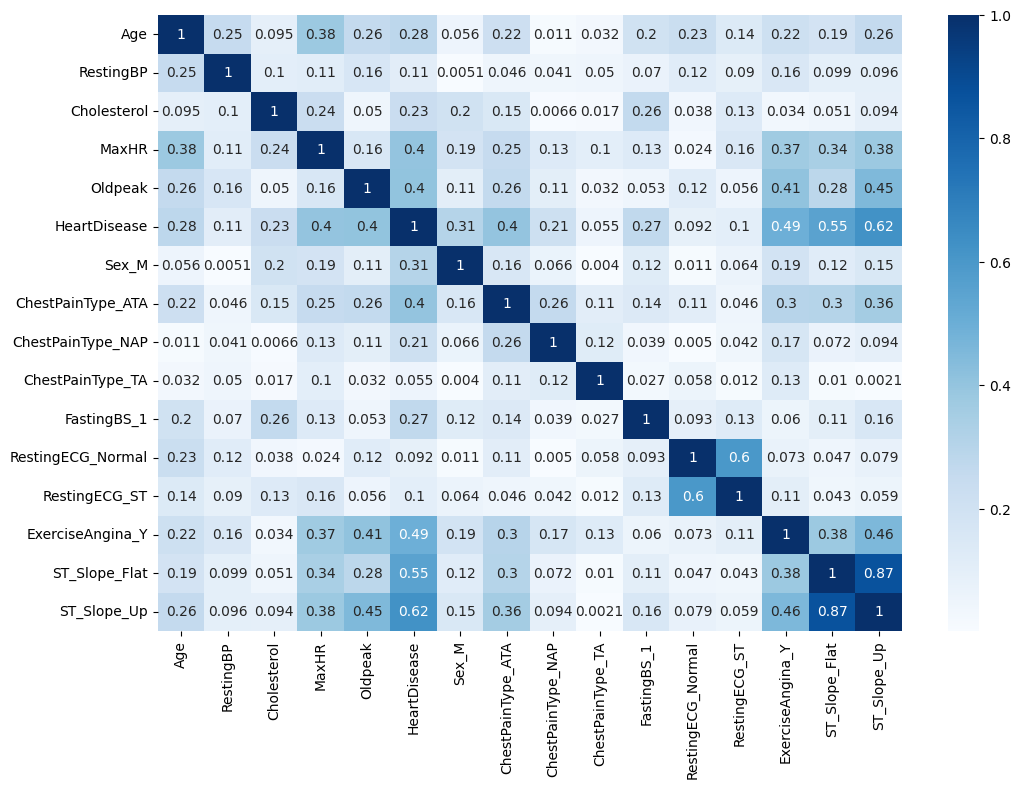

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(hdp_corr, annot = True, cmap= "Blues")


Although this heatmap is useful, it's still a little noisy. Let's just focus on correlations over 0.3.

<Axes: >

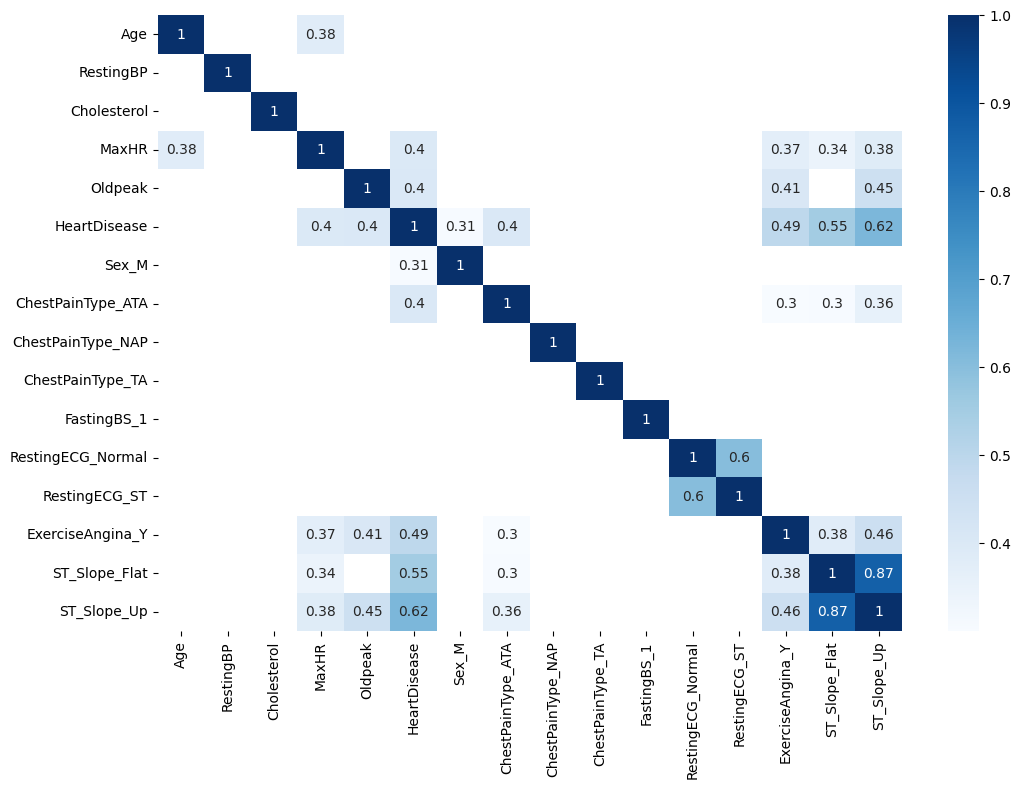

In [17]:
plt.figure(figsize=(12,8))
sns.heatmap(hdp_corr[hdp_corr > 0.3], annot=True, cmap="Blues")

From our correlation heatmap, we can see that a number of features are correlated with heart disease:
*oldpeak

*MaxHR

*ChestPainType_ATA

*ExerciseAngina_Y

*ST_Slope_Flat

*ST_SLOPE_UP

Cholesterol does not seem like a strong indicator of heart disease in this dataset, which is curious. For now, we can narrow down the features we'll us to: OldPeak, Sex_M, ExerciseAngina_Y, ST_Slope_Flat and ST_Slope_Up.

In [34]:
X = hdp_clean.drop("HeartDisease", axis = 1)
y = hdp_clean["HeartDisease"]


X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.15, random_state = 100)

In [35]:
relevant_categorys = [["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak","ChestPainType_ATA", "Sex_M"]]
accuracy_scores = {}
knn = KNeighborsClassifier(n_neighbors=5)
for category in relevant_categorys[0]:
    knn.fit(X_train[[category]],y_train)
    accuracy_scores[category] = f"The accuracy score trained on k=5 for {category} is {round(knn.score(X_val[[category]], y_val) * 100, 2)}%."
    
accuracy_scores
    

{'ExerciseAngina_Y': 'The accuracy score trained on k=5 for ExerciseAngina_Y is 75.36%.',
 'ST_Slope_Flat': 'The accuracy score trained on k=5 for ST_Slope_Flat is 41.3%.',
 'ST_Slope_Up': 'The accuracy score trained on k=5 for ST_Slope_Up is 78.26%.',
 'Oldpeak': 'The accuracy score trained on k=5 for Oldpeak is 69.57%.',
 'ChestPainType_ATA': 'The accuracy score trained on k=5 for ChestPainType_ATA is 41.3%.',
 'Sex_M': 'The accuracy score trained on k=5 for Sex_M is 41.3%.'}

From what we can see from the above, the greatest predictor was ST_Slope_up, followed by Exercise Angina, and then OldPeak

The biggest under performer was chestpaintype_ATA, which may be because it's much more of a general symptom than one specifically to heart disease.

We can make this algorithm more accurate by normalizing the features.


In [41]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train[["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak","ChestPainType_ATA", "Sex_M"]])
X_val_scaled = scaler.transform(X_val[["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak","ChestPainType_ATA", "Sex_M"]])

In [46]:
relevant_categorys = [["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak","ChestPainType_ATA", "Sex_M"]]


knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled,y_train)
accuracy_scores_scaled= knn_scaled.score(X_val_scaled, y_val)
    
print(f"The algorithms accuracy score was {round(accuracy_scores_scaled,2)}%.")

The algorithms accuracy score was 0.83%.


This accuracy score is quite good, however we can further refine it by using a grid search function. Once we have the best parameters, we can use the alogrithm on the test data.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 100)

In [48]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train[["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak","ChestPainType_ATA", "Sex_M"]])
X_test_scaled = scaler.transform(X_test[["ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up", "Oldpeak","ChestPainType_ATA", "Sex_M"]])

grid_params = {"n_neighbors": range(1, 100),
               "metric": ["minkowski", "manhattan"] 
              }
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring="accuracy")

In [53]:
knn_grid.fit(X_train_scaled,y_train)

best_score = knn_grid.best_score_
best_params = knn_grid.best_params_

print(best_score)
print(best_params)

0.8423076923076923
{'metric': 'minkowski', 'n_neighbors': 8}


/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [54]:
knn_final = KNeighborsClassifier(metric = "minkowski", n_neighbors = 8)
knn_final.fit(X_train_scaled, y_train)
print(knn_final.predict(X_test_scaled))

print(f"The accuracy score trained on k=8 was {round(knn_final.score(X_test_scaled, y_test) * 100,2)}%.")


[1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0
 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1
 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1
 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1]
The accuracy score trained on k=8 was 83.33%.


The algorithm has a 83.33% accuracy of correctly identifying whether a patient does or does not have heart disease! Before we celebrate this win however, let's have a quick look at the percentage of male to females in the different datasets to make sure no extra bias has creeped in

In [56]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts(normalize = True))

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts(normalize = True))

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts(normalize = True))

Distribution of patients by their sex in the entire dataset
Sex_M
True     0.78976
False    0.21024
Name: proportion, dtype: float64

Distribution of patients by their sex in the training dataset
Sex_M
True     0.788462
False    0.211538
Name: proportion, dtype: float64

Distribution of patients by their sex in the test dataset
Sex_M
True     0.797101
False    0.202899
Name: proportion, dtype: float64


## Summary and Next Steps

Our final model was trained using the following features:

- `Oldpeak`
- `Sex_M`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

and had a test set accuracy of `86.96`%. However, given the limitations of our data this accuracy might not be indicative of a well performing model. To further our goal

There are quite a few things we could try next to get better results:

- Try out different features.
- Expand the grid search parameters to identify more optimal hyperparameters.
- Explore other algorithms that might perform better than k-NN.
- Try and collect more data.